<b>¡Hola Robert!</b>

Mi nombre es Alejandro Abia y tengo el gusto de revisar tu proyecto. A continuación, encontrarás mis comentarios en celdas pintadas de tres colores(verde, amarillo y rojo), a manera de semáforo. Por favor, <b>no las borres ni muevas de posición</b> mientras dure el proceso de revisión.

<div class="alert alert-block alert-success"><b>Éxito</b> <a class="tocSkip"></a>En celdas verdes encontrarás comentarios en relación a tus aciertos y fortalezas.</div><div class="alert alert-block alert-warning"><b>Atención</b> <a class="tocSkip"></a>Utilizaré el color amarillo para llamar tu atención, expresar algo importante ocompartirte alguna idea de valor.</div><div class="alert alert-block alert-danger"><b>A resolver</b> <a class="tocSkip"></a>En rojo emitiré aquellos puntos que podrían impedir que el proyecto se ejecutecorrectamente. No son errores, sino oportunidades importantes de mejora.</div><div class="alert alert-block alert-info"><b>Comentario estudiante</b><a class="tocSkip"></a> Si durante la revisión deseas dejarme algún comentario, por favor utiliza celdasazules como esta.</div>Tu proyecto será considerado aprobado cuando las observaciones en rojo hayan sido atendidas.

¡Empecemos!

# Telecom

## Predict customer cancellation

## Import Libraries

In [1]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
import numpy as np
from lightgbm import LGBMClassifier
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
import random
import os
import tensorflow as tf

<div class="alert alert-block alert-success"><b>Celda [1]</b> <a class="tocSkip"></a><br>Has hecho un excelente trabajo al importar todas las bibliotecas necesarias alinicio del notebook. Esto es una buena práctica que ayuda a mantener el códigoorganizado y facilita la revisión del mismo.</div>

## Data preprocessing

In [2]:
#Assign contract_df
contract_df = pd.read_csv('/datasets/final_provider/contract.csv')

In [3]:
contract_df.rename(columns={
    'customerID': 'customer_id',
    'BeginDate': 'begin_date',
    'EndDate': 'end_date',
    'Type': 'type',
    'PaperlessBilling': 'paperless_billing',
    'PaymentMethod': 'payment_method',
    'MonthlyCharges': 'monthly_charges',
    'TotalCharges': 'total_charges'
}, inplace=True)

<div class="alert alert-block alert-success"><b>Celda [3]</b> <a class="tocSkip"></a><br>Buena decisión al renombrar las columnas para que sean más descriptivas yconsistentes. Esto mejora la legibilidad del código y facilita el trabajo posteriorcon los datos.</div>

In [4]:
#Convert data to datetime format
contract_df['begin_date'] = pd.to_datetime(contract_df['begin_date'], format='%Y-%m-%d')

In [5]:
#Erase the most recent customers with incomplete data
contract_df = contract_df[contract_df['begin_date'] != "2020-02-01"]

<div class="alert alert-block alert-warning"><b>Celda [5]</b> <a class="tocSkip"></a><br>Eliminar datos basados en fechas específicas puede ser arriesgado si no sejustifica adecuadamente. Asegúrate de que esta decisión esté respaldada por unanálisis que demuestre que estos datos son realmente irrelevantes o incorrectos.</div>

In [6]:
#Convert 'total_charges' column to float type
contract_df.loc[:, 'total_charges'] = contract_df['total_charges'].astype(float)

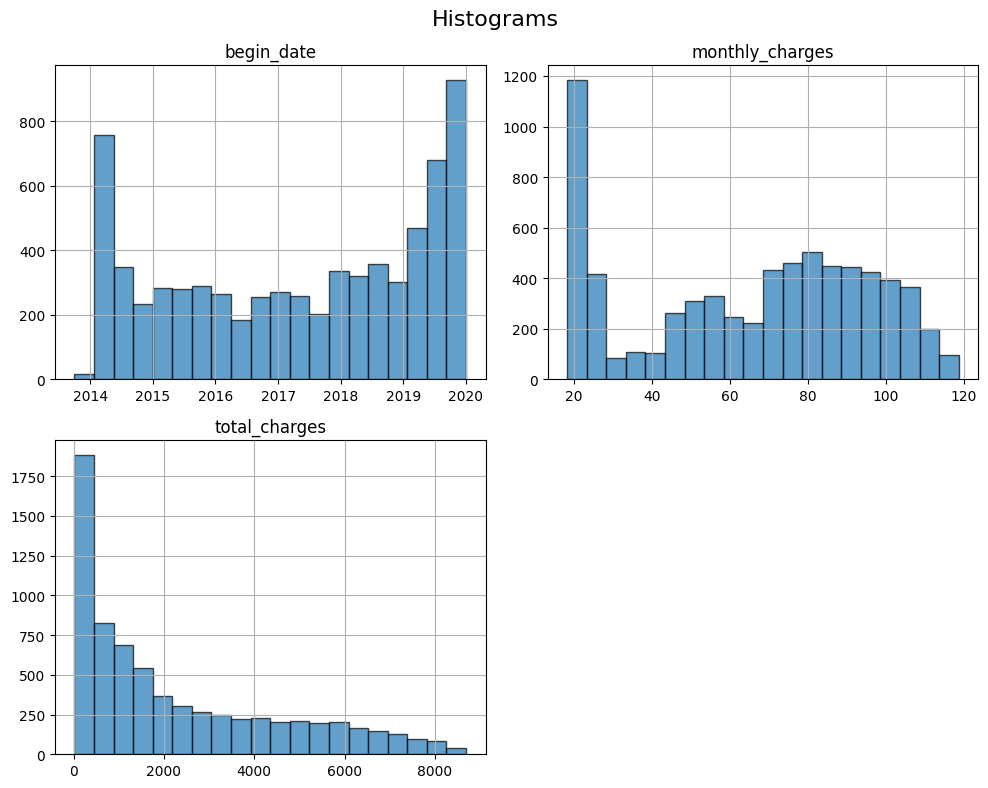

In [7]:
contract_df.hist(figsize=(10, 8), bins=20, edgecolor='black', alpha=0.7)

# Ajustar diseño
plt.suptitle("Histograms", fontsize=16)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success"><b>Celda [7]</b> <a class="tocSkip"></a><br>La visualización de histogramas para entender la distribución de las variables esuna excelente práctica. Esto te permite identificar posibles problemas como sesgoso valores atípicos en los datos.</div>

We notice not normal distribution among the quantitative variables

In [8]:
contract_df.groupby('end_date').size().tail(60)

end_date
2019-10-01 00:00:00     458
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
No                     5163
dtype: int64

All customers that finish their contract, they do it in the months: October, November, December, and January

In [9]:
personal_df = pd.read_csv('/datasets/final_provider/personal.csv')

In [10]:
personal_df.rename(columns={
    'customerID': 'customer_id',
    'SeniorCitizen': 'senior_citizen',
    'Partner': 'partner',
    'Dependents': 'dependents'
}, inplace=True)

In [11]:
internet_df = pd.read_csv('/datasets/final_provider/internet.csv')

In [12]:
internet_df.rename(columns={
    'customerID': 'customer_id',
    'InternetService': 'internet_service',
    'OnlineSecurity': 'online_security',
    'OnlineBackup': 'online_backup',
    'DeviceProtection': 'device_protection',
    'TechSupport': 'tech_support',
    'StreamingTV': 'streaming_tv',
    'StreamingMovies': 'streaming_movies'
}, inplace=True)

In [13]:
phone_df = pd.read_csv('/datasets/final_provider/phone.csv')

In [14]:
phone_df.rename(columns={
    'customerID': 'customer_id',
    'MultipleLines': 'multiple_lines',
}, inplace=True)

In [15]:
#Left merge wich excludes the most recent customer with incomplete information
merged_df = pd.merge(contract_df, personal_df, on='customer_id', how='left')

<div class="alert alert-block alert-success"><b>Celda [15]</b> <a class="tocSkip"></a><br>Al realizar un merge con `how='left'`, asegúrate de que no estás perdiendo información relevante de los otros datasets. Considera verificar la cantidad de datos antes y después del merge para asegurarte de que la operación es correcta.</div>

In [16]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   object        
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   int64         
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(8)
memory usage: 714.2+ KB


In [17]:
merged_df = pd.merge(merged_df, internet_df, on='customer_id', how='outer')

In [18]:
merged_df

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0.0,Yes,No,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0.0,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0.0,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0.0,No,No,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0.0,No,No,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7032,4472-LVYGI,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DSL,Yes,No,Yes,Yes,Yes,No
7033,5709-LVOEQ,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DSL,Yes,Yes,Yes,No,Yes,Yes
7034,1371-DWPAZ,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DSL,Yes,Yes,Yes,Yes,Yes,No
7035,4075-WKNIU,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DSL,No,Yes,Yes,Yes,Yes,No


In [19]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7037 entries, 0 to 7036
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7037 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   object        
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   float64       
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

In [20]:
merged_df.dropna(subset=['begin_date'], inplace=True)

<div class="alert alert-block alert-warning"><b>Celda [20]</b> <a class="tocSkip"></a><br>Al eliminar filas con valores nulos en 'begin_date', podrías estar perdiendo información valiosa. Considera otras estrategias de imputación o justifica porqué estas filas no son relevantes para tu análisis.</div>

In [21]:
#Fill in NaN with 'No' for the customers who don't have such service
merged_df.fillna({
    'internet_service': 'No',
    'online_security': 'No',
    'online_backup': 'No',
    'device_protection': 'No',
    'tech_support': 'No',
    'streaming_tv': 'No',
    'streaming_movies': 'No'
}, inplace=True)

In [22]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   object        
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   float64       
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
 12  internet_service   7032 non-null   object        
 13  online_security    7032 non-null   object        
 14  online_b

In [23]:
# A 'phone_service' column is added since it will be useful...
#...to identify the customers with this service when merging the DFs
phone_df['phone_service'] = 'Yes'

In [24]:
merged_df = pd.merge(merged_df, phone_df, on='customer_id', how='outer')

In [25]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7041 entries, 0 to 7040
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7041 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   object        
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   float64       
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
 12  internet_service   7032 non-null   object        
 13  online_security    7032 non-null   object        
 14  online_b

In [26]:
merged_df.dropna(subset=['begin_date'], inplace=True)

In [27]:
#Fill in NaN with 'No' for the customers who don't have such service
merged_df.fillna({
    'multiple_lines': 'No',
    'phone_service': 'No',
}, inplace=True)

In [28]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   object        
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   float64       
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
 12  internet_service   7032 non-null   object        
 13  online_security    7032 non-null   object        
 14  online_b

In [29]:
#Extract contract begin month data
merged_df['begin_month'] = merged_df['begin_date'].dt.month

In [30]:
#Convert end_date column to datetime unless it has a "No" value
merged_df['end_date'] = pd.to_datetime(merged_df['end_date'], errors='coerce')  # This will convert "No" to NaT

In [31]:
# Calculate the active days
actual_date = pd.to_datetime('2020-02-01', format='%Y-%m-%d')
merged_df['active_days'] = (merged_df['end_date'].fillna(actual_date) - merged_df['begin_date']).dt.days

In [32]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   float64       
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
 12  internet_service   7032 non-null   object        
 13  online_security    7032 non-null   object        
 14  online_b

In [33]:
#Create target column
merged_df['forming_customers'] = merged_df['end_date'].notna()

In [34]:
#Verify the target class balance
merged_df['forming_customers'].value_counts()

False    5163
True     1869
Name: forming_customers, dtype: int64

In [35]:
#Convert object variables to category to train ML models
merged_df[merged_df.select_dtypes(include='object').columns] = merged_df.select_dtypes(include='object').astype('category')

<div class="alert alert-block alert-success"><b>Celda [35]</b> <a class="tocSkip"></a><br>La conversión de variables de tipo objeto a categorías es una buena práctica paraoptimizar el uso de memoria y mejorar la eficiencia del entrenamiento de modelos.</div>

## Split DF into features, target, train, and test subsets

In [36]:
#Select Features from DF
df_features = merged_df.drop(['customer_id', 'begin_date', 'end_date', 'forming_customers'], axis=1)

In [37]:
#Select Target from DF
df_target = merged_df['forming_customers']

In [38]:
#Split features and target into train and test subsets
train_features, test_features, train_target, test_target = train_test_split(df_features, df_target, test_size=0.25, stratify=df_target, random_state=12345)

<div class="alert alert-block alert-success"><b>Celda [38]</b> <a class="tocSkip"></a><br>Has implementado correctamente la separación de los datos en conjuntos deentrenamiento y prueba con estratificación, lo cual es crucial para mantener ladistribución de clases y evitar sesgos en el modelo.</div>

In [39]:
# Verify the class distribution before and after the split
print("Original distribution")
print(df_target.value_counts(normalize=True))

print("\ntrain_target distribution:")
print(train_target.value_counts(normalize=True))

print("\ntest_target distribution:")
print(test_target.value_counts(normalize=True))

Original distribution
False    0.734215
True     0.265785
Name: forming_customers, dtype: float64

train_target distribution:
False    0.734168
True     0.265832
Name: forming_customers, dtype: float64

test_target distribution:
False    0.734357
True     0.265643
Name: forming_customers, dtype: float64


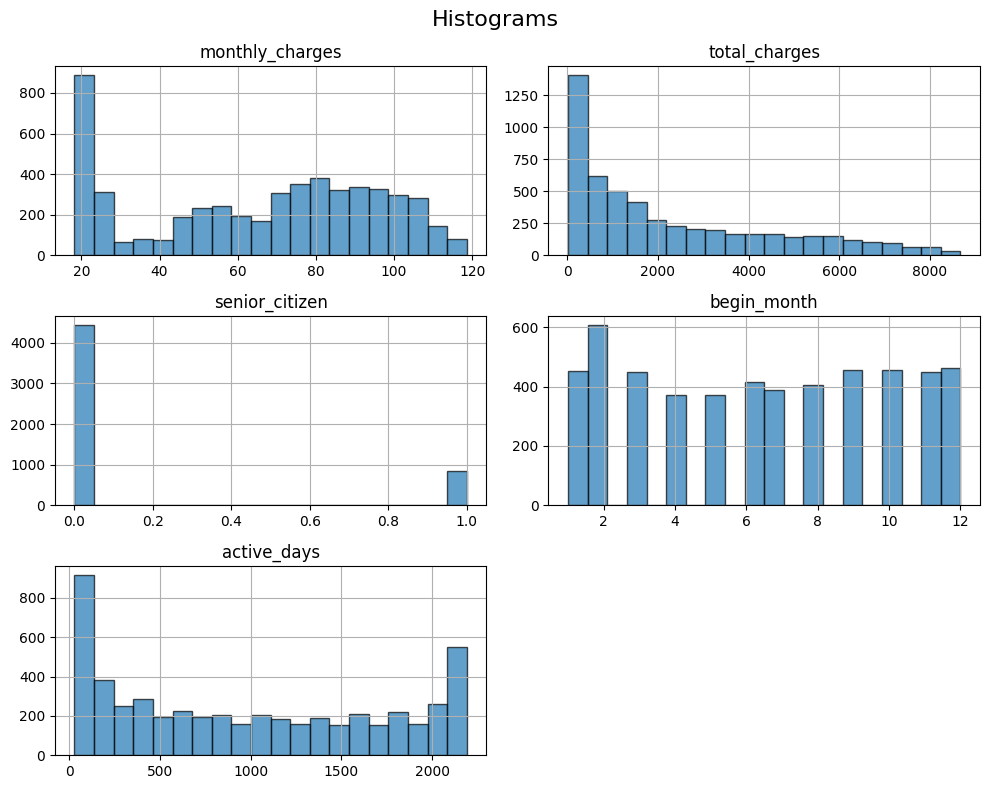

In [40]:
train_features.hist(figsize=(10, 8), bins=20, edgecolor='black', alpha=0.7)

# Ajustar diseño
plt.suptitle("Histograms", fontsize=16)
plt.tight_layout()
plt.show()

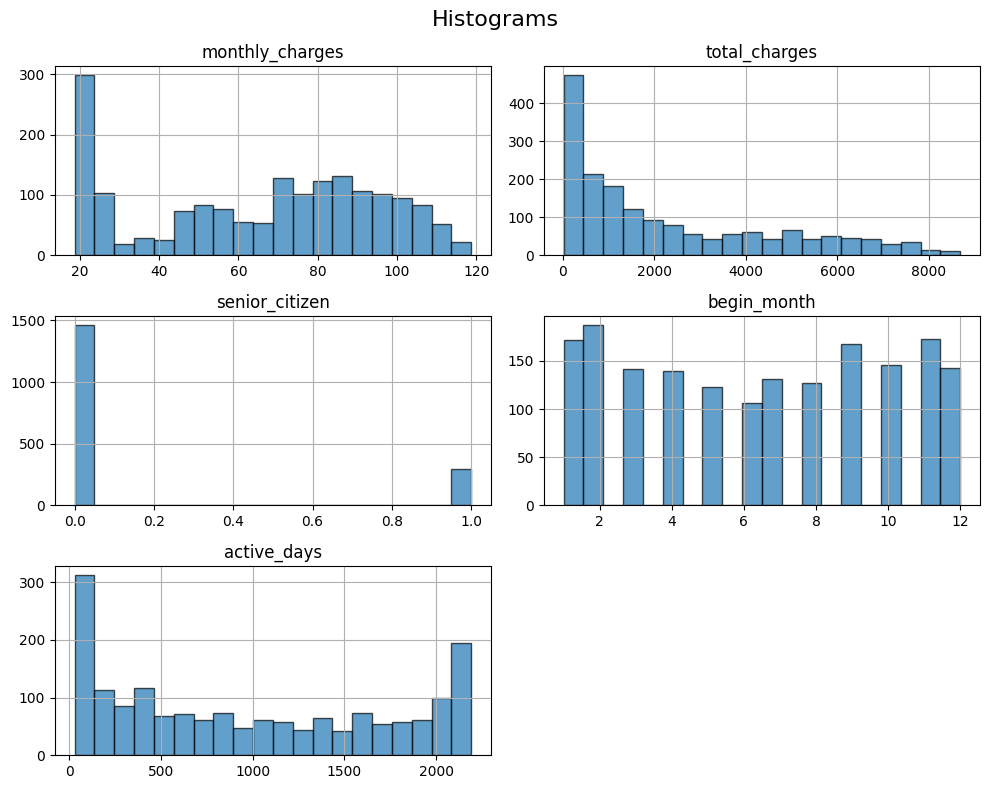

In [41]:
test_features.hist(figsize=(10, 8), bins=20, edgecolor='black', alpha=0.7)

# Ajustar diseño
plt.suptitle("Histograms", fontsize=16)
plt.tight_layout()
plt.show()

The distribution of the features variables among the train and test subsets seem to be similar which is good for the ML model

## Codification

In [42]:
#Substitute contract type data column with ordinal values
type_map = {
    'Month-to-month': 0,
    'One year': 1,
    'Two year': 2
}
train_features.loc[:, 'type'] = train_features['type'].map(type_map).astype('int')
test_features.loc[:, 'type']  = test_features['type'].map(type_map).astype('int')

/.venv/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [43]:
train_features = pd.get_dummies(train_features, drop_first=True)
test_features = pd.get_dummies(test_features, drop_first=True)

<div class="alert alert-success"><b>Celda [43]</b> <a class="tocSkip"></a><br>El uso de One-Hot Encoding es apropiado para variables categórica. Ademas, te aseguraste de eliminar una de las columnas dummy para evitar multicolinealidad. Excelente trabajo.</div>

## Scaling

In [44]:
#Fit and transform train_features
scaler = MinMaxScaler()
scaled_train_features = scaler.fit_transform(train_features)
scaled_train_features = pd.DataFrame(scaled_train_features, columns=train_features.columns)

In [45]:
#Transform test_features
scaled_test_features = scaler.transform(test_features)
scaled_test_features = pd.DataFrame(scaled_test_features, columns=test_features.columns)

## Building ML models

### Define function to evaluate models with K-fold cross validation

In [46]:
def evaluate_model(model, X, y, k_folds=5):
    """
    Evaluates a model with K-fold Cross Validation and calculates the metrics: accuracy, precision, recall, F1, and AUC-ROC.
    
    Parameters:
    model: A Scikit-Learn or compatible machine learning model.
    X: The dataset characteristics.
    y: The target or label of the dataset.
    k_folds: Number of folds in K-fold cross validation.

    Returns:
    dict: A dictionary containing the model's performance metrics.
    """
    # Initialize the StratifiedKFold object for stratified cross-validation
    cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=12345)
    
    # Initialize lists to store metrics for each fold
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    auc_roc_scores = []
    
    # We perform cross-validation
    for train_index, valid_index in cv.split(X, y):
        # Dividir los datos en entrenamiento y prueba
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict the target
        y_pred = model.predict(X_valid)
        
        # Calculate the loss function
        accuracies.append(accuracy_score(y_valid, y_pred))
        precisions.append(precision_score(y_valid, y_pred, average='binary', zero_division=0))
        recalls.append(recall_score(y_valid, y_pred, average='binary'))
        f1_scores.append(f1_score(y_valid, y_pred, average='binary'))
        
        # AUC-ROC only for binary classification
        if len(np.unique(y)) == 2:  # only for binary classification
            auc_roc_scores.append(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))
        else:
            auc_roc_scores.append(np.nan)  # If not binary, no calculation of AUC-ROC

    # Calculation of loss function means
    metrics = {
        'accuracy': np.mean(accuracies),
        'precision': np.mean(precisions),
        'recall': np.mean(recalls),
        'f1_score': np.mean(f1_scores),
        'auc_roc': np.nanmean(auc_roc_scores)  # If there are Nans in AUC-ROC, it will be ignored
    }
    
    return metrics

### Logistic Regression Model

In [47]:
#Define Logistic Regression Model
lr_model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=12345)

In [48]:
evaluate_model(lr_model, scaled_train_features, train_target, k_folds=5)

{'accuracy': 0.7525568135831003,
 'precision': 0.5228284765116491,
 'recall': 0.8052897813929842,
 'f1_score': 0.6339070533793739,
 'auc_roc': 0.8448714942716361}

<div class="alert alert-block alert-success"><b>Celda [48]</b> <a class="tocSkip"></a><br>La función `evaluate_model` es una implementación robusta para evaluar elrendimiento del modelo con múltiples métricas, lo que proporciona una visióncompleta de su desempeño.</div>

In [49]:
lr_model.fit(scaled_train_features, train_target)

LogisticRegression(class_weight='balanced', random_state=12345,
                   solver='liblinear')

### Random Forest Classifier Model

In [50]:
#Define the base model
rfc_model = RandomForestClassifier(class_weight='balanced', random_state=12345)

#Define the hyperparameter search space
param_grid = {
    'n_estimators': [10, 50, 100],   # Number of trees in the forest
    'max_depth': [3, 5, None],       # Tree maximal depth
    'min_samples_split': [2, 5, 10], # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4]    # Minimum samples on a leaf
}

#Define the loss function to optimize
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

#Set up `GridSearchCV`
grid_search = GridSearchCV(
    rfc_model, param_grid, cv=5, scoring=scoring, refit='f1', n_jobs=-1, verbose=1
)

#Train the model and find the best hyperparameters
grid_search.fit(train_features, train_target)

#Getting the best trained model 
best_rfc = grid_search.best_estimator_

# Show the best hyperparameters and the final accuracy
print("Best hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


<div class="alert alert-block alert-warning"><b>Celda [50]</b> <a class="tocSkip"></a><br>El uso de `GridSearchCV` para optimizar hiperparámetros es una excelente práctica. Sin embargo, asegúrate de que los parámetros a evaluar son adecuados para el modeloen cuestión. Revisa si todos los parámetros en `param_grid` son aplicables al modeloque estás utilizando.</div>

In [51]:
rfc_model =  RandomForestClassifier(
    class_weight='balanced',
    n_estimators=50,     # Number of trees in the forest
    max_depth=None,      # Tree maximal depth
    min_samples_split=2, # Minimum samples to split a node
    min_samples_leaf=2,  # Minimum samples on a leaf
    random_state=12345
)

In [52]:
evaluate_model(rfc_model, train_features, train_target)

{'accuracy': 0.8445181075029001,
 'precision': 0.730225474144655,
 'recall': 0.6591001525165227,
 'f1_score': 0.692476882528671,
 'auc_roc': 0.8901335983949386}

In [53]:
rfc_model.fit(train_features, train_target)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=2,
                       n_estimators=50, random_state=12345)

### Gradient Boosting Classifier Model

In [54]:
#Define the base Gradient Boosting Classifier model
lgb_model = LGBMClassifier(class_weight='balanced', random_state=12345)

In [55]:
#Define the hyperparameter search space
param_grid = {
    'n_estimators': [10, 50, 100],   # Number of trees in the forest
    'max_depth': [3, 5, None],       # Tree maximal depth
    'min_samples_split': [2, 5, 10], # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4]    # Minimum samples on a leaf
}

#Define the loss function to optimize
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

#Set up `GridSearchCV`
grid_search = GridSearchCV(
    lgb_model, param_grid, cv=5, scoring=scoring, refit='f1', n_jobs=-1, verbose=1
)

#Train the model and find the best hyperparameters
grid_search.fit(train_features, train_target)

#Getting the best trained model 
best_lgb = grid_search.best_estimator_

# Show the best hyperparameters and the final accuracy
print("Best hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_lea

In [56]:
lgb_model =  LGBMClassifier(
    class_weight='balanced',
    n_estimators=100,     # Number of trees in the forest
    max_depth=None,      # Tree maximal depth
    min_samples_split=2, # Minimum samples to split a node
    min_samples_leaf=4,  # Minimum samples on a leaf
    random_state=12345
)

In [57]:
evaluate_model(lgb_model, train_features, train_target)

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] Unknown parameter: min_samples_split


{'accuracy': 0.981607597327266,
 'precision': 0.9939506976071713,
 'recall': 0.9365099135739706,
 'f1_score': 0.9642797901720158,
 'auc_roc': 0.9915567869979697}

In [58]:
lgb_model.fit(train_features, train_target)

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] Unknown parameter: min_samples_split


LGBMClassifier(class_weight='balanced', max_depth=None, min_samples_leaf=4,
               min_samples_split=2, random_state=12345)

### Deep Learning Model

In [59]:
# Reproducibility seed
SEED = 12345
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [60]:
#Define base model
dl_model = Sequential()
dl_model.add(Dense(
    10,
    input_dim=scaled_train_features.shape[1],
    activation='relu'
))
dl_model.add(Dropout(0.3))
dl_model.add(Dense(
    units=1,
    activation='sigmoid'
))
dl_model.compile(
    optimizer=Adam(0.0001),
    loss='binary_crossentropy',
    metrics=['AUC']
)

2025-06-26 03:34:32.551706: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [61]:
#Train dl_model
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_target),
    y=train_target
)
class_weight_dict = dict(enumerate(class_weights))

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce LROnPlateau to reduce the learning if the metric does not improve
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

historial = dl_model.fit(
    scaled_train_features,
    train_target,
    verbose=2,
    batch_size=32,
    validation_split=0.2,
    epochs=50,
    class_weight=class_weight_dict
)

Epoch 1/50
132/132 - 1s - loss: 0.7384 - auc: 0.5493 - val_loss: 0.8288 - val_auc: 0.5726 - 743ms/epoch - 6ms/step
Epoch 2/50
132/132 - 0s - loss: 0.7149 - auc: 0.5715 - val_loss: 0.7844 - val_auc: 0.5937 - 142ms/epoch - 1ms/step
Epoch 3/50
132/132 - 0s - loss: 0.6983 - auc: 0.5869 - val_loss: 0.7483 - val_auc: 0.6163 - 131ms/epoch - 994us/step
Epoch 4/50
132/132 - 0s - loss: 0.6849 - auc: 0.6089 - val_loss: 0.7203 - val_auc: 0.6353 - 133ms/epoch - 1ms/step
Epoch 5/50
132/132 - 0s - loss: 0.6794 - auc: 0.6174 - val_loss: 0.6991 - val_auc: 0.6527 - 134ms/epoch - 1ms/step
Epoch 6/50
132/132 - 0s - loss: 0.6663 - auc: 0.6465 - val_loss: 0.6789 - val_auc: 0.6690 - 140ms/epoch - 1ms/step
Epoch 7/50
132/132 - 0s - loss: 0.6582 - auc: 0.6612 - val_loss: 0.6634 - val_auc: 0.6826 - 131ms/epoch - 989us/step
Epoch 8/50
132/132 - 0s - loss: 0.6551 - auc: 0.6657 - val_loss: 0.6497 - val_auc: 0.6959 - 125ms/epoch - 947us/step
Epoch 9/50
132/132 - 0s - loss: 0.6476 - auc: 0.6825 - val_loss: 0.6374 - 

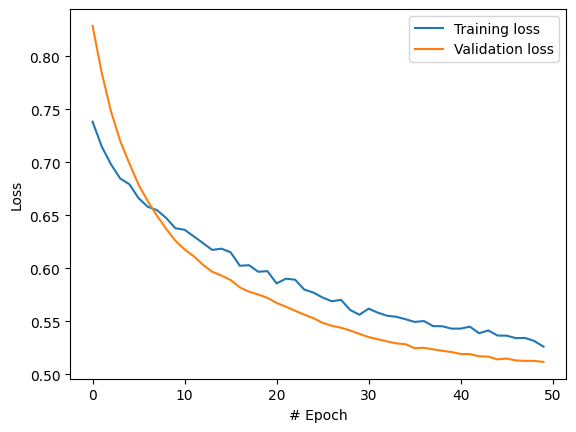

In [62]:
plt.xlabel("# Epoch")
plt.ylabel("Loss")
plt.plot(historial.history["loss"], label='Training loss')
plt.plot(historial.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

As another epoch runs the loss function decreases progressively until it reaches a point in which it doesn't get any better

## Final evaluation of every model in Test Sets

In [63]:
def evaluate_on_test_set(model, X_test, y_test):
    """
    Evaluates a model on the final test set using the metrics: accuracy, precision, recall, F1, and AUC-ROC.

    Parameters:
    model: A pre-trained machine learning model.
    X_test: The set of features for the test set.
    y_test: The set of labels for the test set.

    Returns:
    dict: A dictionary containing the model's performance metrics on the test set.
    """
    
    # Predict the target with the trained model
    y_pred = model.predict(X_test)
    
    # Initialize a dictionary for metrics
    metrics = {}
    
    # Calculate performance metrics
    metrics['accuracy'] = accuracy_score(y_test, y_pred)
    metrics['precision'] = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    metrics['recall'] = recall_score(y_test, y_pred, average='weighted')
    metrics['f1_score'] = f1_score(y_test, y_pred, average='weighted')
    
    # AUC-ROC only for binary or multiclass classification One-vs-Rest
    if len(np.unique(y_test)) == 2:  #For binary classification only
        metrics['auc_roc'] = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    else:
        try:
            metrics['auc_roc'] = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
        except ValueError:
            metrics['auc_roc'] = np.nan  # If AUC-ROC cannot be calculated, assign NaN
    
    return metrics


In [64]:
print('Logistic Regression Model Test Performance')
evaluate_on_test_set(lr_model, scaled_test_features, test_target)

Logistic Regression Model Test Performance


{'accuracy': 0.757679180887372,
 'precision': 0.8155502649984046,
 'recall': 0.757679180887372,
 'f1_score': 0.7704958932586873,
 'auc_roc': 0.8578480237917919}

In [65]:
print('Random Forest Classifier Model Test Performance')
evaluate_on_test_set(rfc_model, test_features, test_target)

Random Forest Classifier Model Test Performance


{'accuracy': 0.8629124004550626,
 'precision': 0.859804958506644,
 'recall': 0.8629124004550626,
 'f1_score': 0.8607272632422424,
 'auc_roc': 0.9018497355269641}

In [66]:
print('Light Gradient Boosting Machine Model Test Performance')
evaluate_on_test_set(lgb_model, test_features, test_target)

Light Gradient Boosting Machine Model Test Performance


{'accuracy': 0.9840728100113766,
 'precision': 0.9842267198156478,
 'recall': 0.9840728100113766,
 'f1_score': 0.9839479865026434,
 'auc_roc': 0.9968999679878985}

In [67]:
# Evaluate metrics of the dl_model in the test sets
# Get predictions
# The model returns probabilities, so we convert them to 0/1 classes
y_prob = dl_model.predict(scaled_test_features)
y_pred = (y_prob > 0.5).astype("int32").flatten()

# Metrics calculation
metrics = {}
metrics['accuracy'] = accuracy_score(test_target, y_pred)
metrics['precision'] = precision_score(test_target, y_pred, average='weighted', zero_division=0)
metrics['recall'] = recall_score(test_target, y_pred, average='weighted')
metrics['f1_score'] = f1_score(test_target, y_pred, average='weighted')
metrics['auc_roc'] = roc_auc_score(test_target, y_prob)

# Show results
print('Deep Learning Model Test Performance')
for key, value in metrics.items():
    print(f"{key.capitalize()}: {value:.4f}")


Deep Learning Model Test Performance
Accuracy: 0.7548
Precision: 0.8037
Recall: 0.7548
F1_score: 0.7670
Auc_roc: 0.8356


<div class="alert alert-block alert-success"><b>Comentario final</b> <a class="tocSkip"></a><br>¡Muy buen trabajo, Robert! A lo largo del proyecto mostraste fortalezas muyclaras:<br><br>• Importaste todas las bibliotecas necesarias al inicio del notebook, lo que ayudaa mantener el código organizado.<br>• Renombraste las columnas para mejorar la legibilidad del código.<br>• Utilizaste histogramas para entender la distribución de las variables, lo cual esfundamental para identificar problemas potenciales.<br>• Implementaste correctamente la separación de los datos en conjuntos deentrenamiento y prueba con estratificación.<br>• Convertiste variables de tipo objeto a categorías, optimizando así el uso dememoria.<br>• Aplicaste One-Hot Encoding de manera adecuada, eliminando una de las columnasdummy para evitar multicolinealidad.<br>• Usaste `GridSearchCV` para optimizar hiperparámetros, mostrando un enfoquemeticuloso en la mejora del modelo.<br>• Implementaste una función robusta para evaluar el modelo con múltiples métricas.<br>• Mostraste un buen manejo de técnicas avanzadas de modelado y evaluación.<br>• Mantuviste un flujo de trabajo claro y bien documentado.<br><br>¡Felicidades!

## Conclusions

The model with the best test performance was the Light Gradient Boosting Machine.

It was achieved a AUC-ROC metric of 0.997

This trained model can be deployed to start making predictions on field